In [1]:
#  refine P-wave arrival and calculate theoretical sP-P differential time
import os
import glob
import obspy
import time
from obspy.taup import TauPyModel
from obspy.clients.iris import Client
client = Client()
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.trigger import classic_sta_lta
from IPython.display import clear_output

data_sac="./Download/SAC"

file_path_good = "./Download/judge_good.info"
if not os.path.exists(f"{file_path_good}"):
    file = open(file_path_good, 'w')
    file.close()
    print("Good File Created")
else:
    print("Good File already exists")
    
file_path_bad = "./Download/judge_bad.info"
if not os.path.exists(f"{file_path_bad}"):
    file = open(file_path_bad, 'w')
    file.close()
    print("Bad File Created")
else:
    print("File already exists")

Good File already exists
File already exists


In [2]:
file1 = open("./Download/judge_good.info", "r")
file2 = open("./Download/judge_bad.info", "r")

ids = len(file1.readlines()) + len(file2.readlines())
file1.close()
file2.close()


In [3]:
ids

1196

3 Trace(s) in Stream:
C1.BO03..BHR | 2020-12-12T07:12:40.268867Z - 2020-12-12T07:14:34.818867Z | 100.0 Hz, 11456 samples
C1.BO03..BHT | 2020-12-12T07:12:40.268867Z - 2020-12-12T07:14:34.818867Z | 100.0 Hz, 11456 samples
C1.BO03..BHZ | 2020-12-12T07:12:40.268867Z - 2020-12-12T07:14:34.818867Z | 100.0 Hz, 11456 samples

63 1500
19.77 244.64914 4.5

TP actual= 35.446s  TP refined= 35.446s  TsPmP= 46.146s  TsPn= 43.168s

TP refined - TP actual= 0.000s

TsPmP-TP actual= 10.700s  TsPmP-TP refined= 10.700s

TsPn-TP actual= 7.722s  TsPn-TP refined= 7.722s


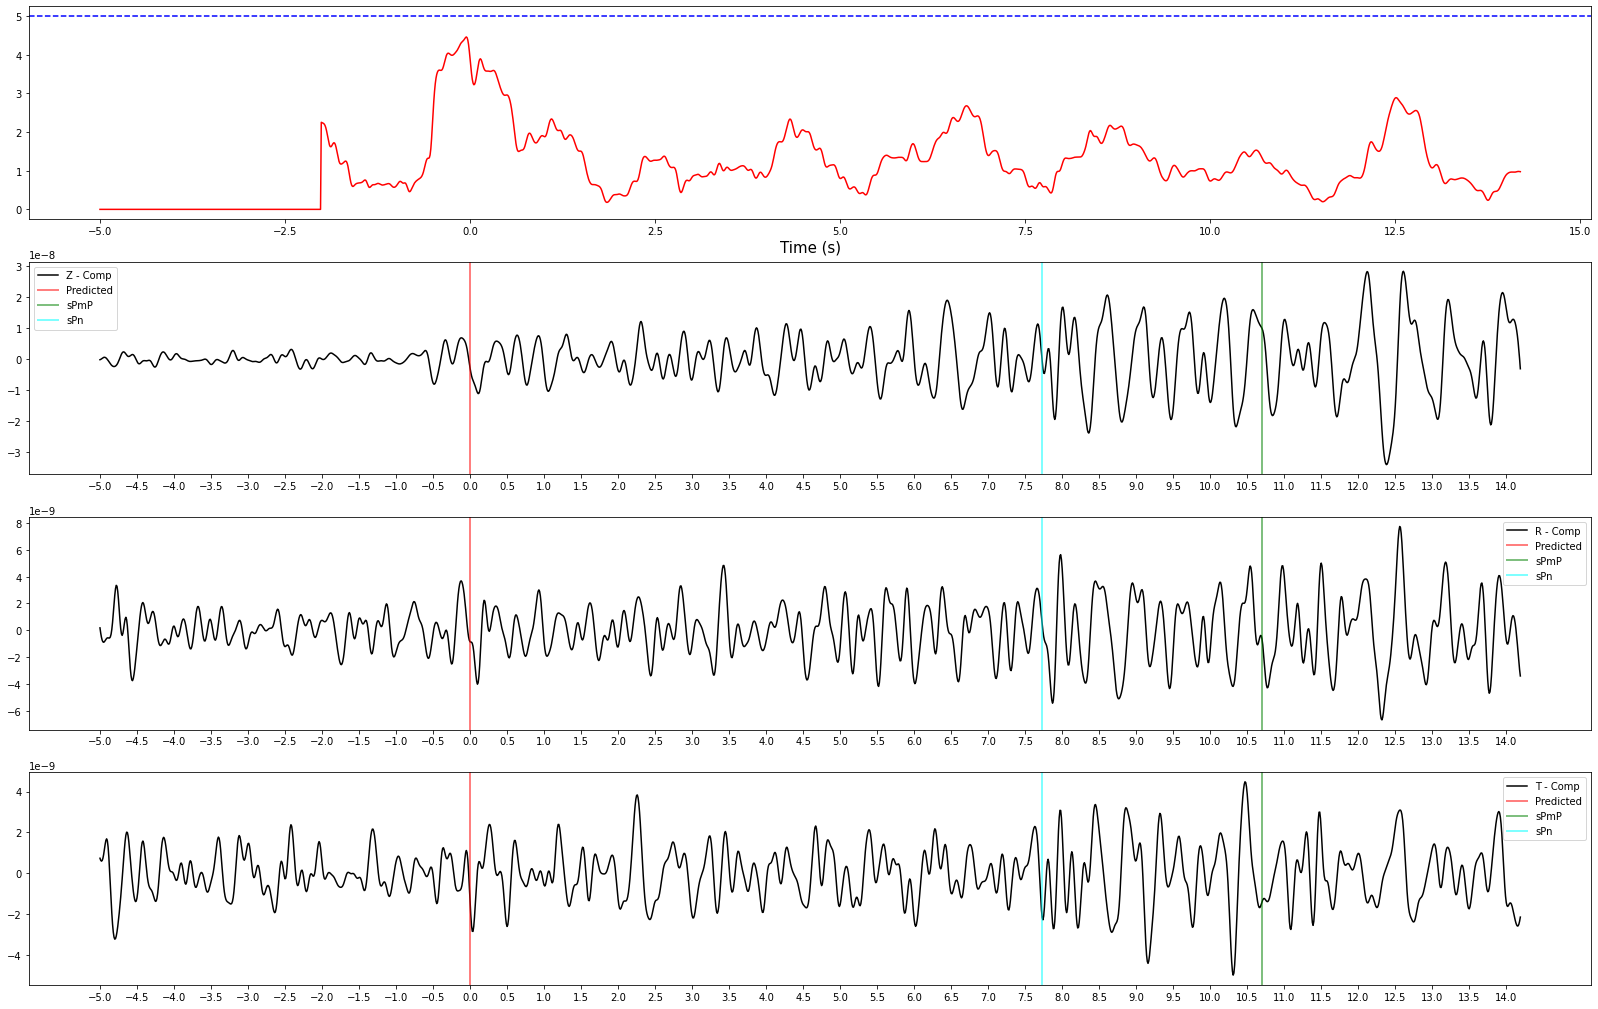

KeyboardInterrupt: Interrupted by user

In [7]:
file1 = open("./Download/judge_good.info", "r")
file2 = open("./Download/judge_bad.info", "r")
ids = len(file1.readlines()) + len(file2.readlines())

file1.close()
file2.close()

count = 0
evcount = 0
for ev in os.listdir(data_sac):
        print()
        print(ev)
        evcount+=1
        print(evcount)
        print()
        
        inpath = os.path.join(data_sac, ev)
        if len(glob.glob(f"{inpath}/*R.SAC.bp.cut")) == 0:
            continue
        else:            
            funiq = []
            for sac in glob.glob(f"{inpath}/*R.SAC.bp.cut"):
                st = obspy.read(sac)
                funiq.append("{}.{}.{}".format(st[0].stats.network,st[0].stats.station,st[0].stats.location))
            fU = sorted(set(funiq))

            for sacfile in fU:
                count+=1
                if(count<ids):
                    
                    print("skipped ", count)
                    continue

                st = obspy.read(f"{inpath}/{sacfile}*[RTZ].SAC.bp.cut")
                sachd = st[0].stats.sac
                print(st)
                print()
                print(evcount, count)
                print(sachd["evdp"],sachd["dist"], sachd['mag'])

                    

                    ### calculate the theoretical sP-P differential time
                model = TauPyModel(model="iasp91")

                distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
                gcarc = distaz['distance']
                arrival = model.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["sPvmP"])
                TsPmP = arrival[0].time
                arrival = model.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["sPn"])
                if len(arrival) != 0:
                    TsPn = float("{:.3f}".format(arrival[0].time))
                    TsPn1 = TsPn
                else:
                    TsPn = "nan"
                    TsPn1 = 0
                
                
                
                ### refine P-wave arrival using sta/lta method
                df = st[0].stats.sac.delta
                Tp1 = 0 - st[0].stats.sac.o
                
                    # time window
                idx1 = int((st[0].stats.sac.t1-5-st[0].stats.sac.b)/st[0].stats.delta)
                idx2 = int((st[0].stats.sac.t1+(max(TsPmP,TsPn1)-Tp1)+3.5-st[0].stats.sac.b)/st[0].stats.delta)
                cft = classic_sta_lta(st[2].data[idx1:idx2], int(0.5/df), int(3/df))   # 0.5s short-term window; 3.0s long-term window
                if len(np.where(cft>5)[0]) != 0:
                    Tp = -5 + np.where(cft>5)[0][0]*df + 0.25 - st[0].stats.sac.o
                else:
                    Tp = 0 - st[0].stats.sac.o
                    
                print("\nTP actual= {:.3f}s  TP refined= {:.3f}s  TsPmP= {:.3f}s  TsPn= {}s".format(Tp1, Tp, TsPmP, TsPn))
                print("\nTP refined - TP actual= {:.3f}s".format(Tp-Tp1))
                print("\nTsPmP-TP actual= {:.3f}s  TsPmP-TP refined= {:.3f}s".format(TsPmP-Tp1, TsPmP-2*Tp1+Tp))
                if(TsPn != 'nan'):
                    print("\nTsPn-TP actual= {:.3f}s  TsPn-TP refined= {:.3f}s".format(TsPn-Tp1, TsPn-2*Tp1+Tp))
                
                #t = np.arange(st[0].stats.sac.t1-5, st[0].stats.sac.t1+20, st[0].stats.delta)
                t = np.arange(st[0].stats.sac.t1-5, st[0].stats.sac.t1+(max(TsPmP,TsPn1)-Tp1)+3.5, st[0].stats.delta)

                    ### Plot the waveform

                try:
                    plt.figure(figsize=(28,18))
                    plt.subplot(411)
                    plt.plot(t,cft,color="red")
                    plt.axhline(y=5, color='blue', linestyle='--')
                    plt.xlabel("Time (s)",fontsize=15)
                except:
                    t=t[:-1]
                    plt.clf()
                    
                    plt.figure(figsize=(28,18))
                    plt.subplot(411)
                    plt.plot(t, cft, color='red')
                    plt.axhline(y=5, color='blue', linestyle='--')
                    plt.xlabel("Time (s)",fontsize=15)
                
                
                
                plt.subplot(412)
                plt.plot(t,st[2].data[idx1:idx2],color="black", label = 'Z - Comp')
                plt.xticks(np.arange(t[0], t[-1]+0.1, 0.5))
                plt.axvline(x=st[2].stats.sac.t1, color="red", alpha=0.5, linewidth=2,label="Predicted")
                if len(np.where(cft>5)[0]) != 0:
                    plt.axvline(x=-5+np.where(cft>5)[0][0]*df+0.25, color="blue", alpha=0.5, linewidth=2,label="Refined")
                plt.axvline(x=TsPmP+Tp-2*Tp1, color="green", alpha=0.5, linewidth=2, label="sPmP")
                if TsPn != "nan":
                    plt.axvline(x=TsPn+Tp-2*Tp1, color="cyan", alpha=0.5, linewidth=2, label="sPn")
               
                plt.legend()
                
                plt.subplot(413)
                plt.plot(t,st[0].data[idx1:idx2],color="black", label = 'R - Comp')
                plt.xticks(np.arange(t[0], t[-1]+0.1, 0.5))
                plt.axvline(x=st[2].stats.sac.t1, color="red", alpha=0.5, linewidth=2,label="Predicted")
                if len(np.where(cft>5)[0]) != 0:
                    plt.axvline(x=-5+np.where(cft>5)[0][0]*df+0.25, color="blue", alpha=0.5, linewidth=2,label="Refined")
                plt.axvline(x=TsPmP+Tp-2*Tp1, color="green", alpha=0.5, linewidth=2, label="sPmP")
                if TsPn != "nan":
                    plt.axvline(x=TsPn+Tp-2*Tp1, color="cyan", alpha=0.5, linewidth=2, label="sPn")
                plt.legend()
                
                plt.subplot(414)
                plt.plot(t,st[1].data[idx1:idx2],color="black", label = 'T - Comp')
                plt.xticks(np.arange(t[0], t[-1]+0.1, 0.5))
                plt.axvline(x=st[2].stats.sac.t1, color="red", alpha=0.5, linewidth=2,label="Predicted")
                if len(np.where(cft>5)[0]) != 0:
                    plt.axvline(x=-5+np.where(cft>5)[0][0]*df+0.25, color="blue", alpha=0.5, linewidth=2,label="Refined")
                plt.axvline(x=TsPmP+Tp-2*Tp1, color="green", alpha=0.5, linewidth=2, label="sPmP")
                if TsPn != "nan":
                    plt.axvline(x=TsPn+Tp-2*Tp1, color="cyan", alpha=0.5, linewidth=2, label="sPn")
                plt.legend()
                
                plt.show()

                quality = input("Quality: y(good) or n(bad)")
                time.sleep(1)

                if quality == "y":
                    file = open("./Download/judge_good.info", "a")
                    file.write("Info: {} {} Tp: {} TsPmP: {} TsPn: {}\n".format(ev, sacfile, Tp, TsPmP, TsPn))
                    file.close()
                else:
                    file = open("./Download/judge_bad.info", "a")
                    file.write("Info: {} {} Tp: {} TsPmP: {} TsPn: {}\n".format(ev, sacfile, Tp, TsPmP, TsPn))
                    file.close()
                clear_output(wait=True)
